In [1]:
import pandas as pd
import geopandas as gpd
import os
from datetime import datetime
import re
import numpy as np
import folium
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import sys

from together import Together  # pip install together
sys.path.insert(1, '../')
from Functions import get_gentrification_scores, map_static, get_gentrification_scores_categorical

In [2]:
city = 'manchester'

In [9]:
neighbourhoods = gpd.read_file(f"../../../data/AirbnbData/airbnb-{city}/neighbourhoods.geojson")

### Join together 4 sets of listings, removing duplicates

In [10]:
listings_mar = pd.read_csv(f"../../../data/AirbnbData/airbnb-{city}/listings_mar24.csv.gz")
listings_jun = pd.read_csv(f"../../../data/AirbnbData/airbnb-{city}/listings_jun24.csv.gz")
listings_sept = pd.read_csv(f"../../../data/AirbnbData/airbnb-{city}/listings_sept24.csv.gz")
listings_dec = pd.read_csv(f"../../../data/AirbnbData/airbnb-{city}/listings_dec24.csv.gz")

In [11]:
# Add a column indicating the source dataframe
listings_mar["source"] = "Mar"
listings_jun["source"] = "Jun"
listings_sept["source"] = "Sept"
listings_dec["source"] = "Dec"

# Concatenate the two dataframes
combined = pd.concat([listings_mar, listings_jun, listings_sept, listings_dec, ])

# Group by listing ID and collect sources
combined["source"] = combined.groupby(["id", "listing_url", 'name'])["source"].transform(lambda x: ", ".join(sorted(set(x))))

# Drop duplicates based on listing ID (keeping the first occurrence)
final_listings = combined.drop_duplicates(subset="id").reset_index(drop=True)
len(final_listings)

10109

### Count the number of listings in each LSOA

In [15]:
lsoas =  gpd.read_file('../../../data/SpatialData/LSOAs_2011/LSOA_2011_EW_BSC_V4.shp')
manc_lads = ['Manchester', 'Rochdale', 'Bolton', 'Bury', 'Wigan', 'Oldham',  'Trafford', 'Salford', 'Tameside', 'Stockport']
pattern = '|'.join(manc_lads)
manchester_lsoas =lsoas[lsoas['LSOA11NMW'].str.contains(pattern)]
manchester_lsoas.head()

,LSOA11CD,LSOA11NM,LSOA11NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
4642,E01004766,Bolton 005A,Bolton 005A,371186,411551,-2.43686,53.5997,29ec009d-28d2-4b2d-856d-0041ff7a2c28,"POLYGON ((371525.9 411866.915, 371336.156 4111..."
4643,E01004767,Bolton 005B,Bolton 005B,371871,411508,-2.42651,53.5994,59bd0d32-eae4-42bc-a7f8-d6e76e7372e3,"POLYGON ((372192.155 411874.385, 372403.344 41..."
4644,E01004768,Bolton 001A,Bolton 001A,370034,413227,-2.45443,53.6147,9a70e214-0a97-4484-a7c2-d97bad70ecb2,"POLYGON ((370698.947 414430.285, 370868.309 41..."
4645,E01004769,Bolton 003A,Bolton 003A,371943,412792,-2.42554,53.6109,c06d3924-84ea-48c6-abd1-43632303a4f2,"POLYGON ((371827.566 413132.13, 372260.979 412..."
4646,E01004770,Bolton 003B,Bolton 003B,372075,412156,-2.42349,53.6052,7d761bb4-224f-4fc9-81b0-c7a843c07335,"POLYGON ((372545.065 412625.806, 372192.155 41..."


In [16]:
final_listings['geometry'] = final_listings.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
final_listings_gdf = gpd.GeoDataFrame(final_listings, geometry='geometry', crs="EPSG:4326")
final_listings_gdf = final_listings_gdf.to_crs(manchester_lsoas.crs)
final_listings_gdf = gpd.sjoin(final_listings_gdf, manchester_lsoas[['LSOA11NM', 'geometry']], how='left', predicate='within')

In [17]:
# Find the most common score in each LSOA
count = final_listings_gdf.groupby("LSOA11NM").size()
count_filtered = count[count >8]
count_filtered.name = 'Count'
manchester_lsoas = manchester_lsoas.sort_values(by='LSOA11NM')
manchester_lsoas = manchester_lsoas.merge(count_filtered, on='LSOA11NM', how='left')

### Filter to only keep LSOAs within a 6000m buffer zone of the centre of Manchester

In [18]:
# Reproject to a CRS with meters (British National Grid)
manchester_lsoas = manchester_lsoas.to_crs(epsg=27700)

# Define Manchester city centre point (in WGS84, then project)
city_centre_wgs84 = Point(-2.2426, 53.4808)  # approx lat/lon of Manchester city centre
city_centre_point = gpd.GeoSeries([city_centre_wgs84], crs='EPSG:4326').to_crs(epsg=27700).iloc[0]

# Filter polygons within a buffer distance (e.g., 3 km radius)
buffer = city_centre_point.buffer(6000)  # 3000 meters
central_lsoas = manchester_lsoas[manchester_lsoas.intersects(buffer)]

Text(0.5, 1.0, 'All')

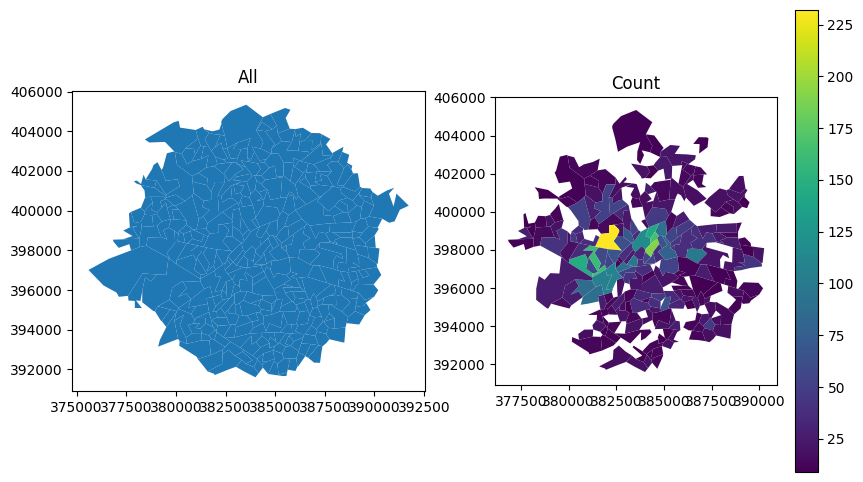

In [19]:
fig, axs = plt.subplots(ncols =2, figsize=(10, 6))  # Ensure equal subplot sizes
central_lsoas.plot(ax=axs[1], column ='Count',  legend=True)  # Disable auto legend
central_lsoas.plot(ax=axs[0],  legend=True)  # Disable auto legend
axs[1].set_title("Count")
axs[0].set_title("All")

In [11]:
final_listings_gdf = final_listings_gdf[final_listings_gdf['LSOA11NM'].isin(central_lsoas['LSOA11NM'].unique())]
final_listings = final_listings_gdf.copy()
del final_listings['geometry']

In [12]:
# map_center = [final_listings["latitude"].mean(), final_listings["longitude"].mean()]

# # Create a Folium map
# m = folium.Map(location=map_center, zoom_start=12, tiles="CartoDB Positron")

# for _, row in final_listings.iterrows():
#     popup_text = (
#         f"Text: {row['source']}<br>"
#         f"Name: {row['name']}<br>")
#     # Assign color based on predefined mapping or default to gray
#     color = "purple" if "Jun" in row['source'] else "lime" if "Dec" in row['source'] else "yellow" if "Mar" in row['source'] else "black"

#     folium.CircleMarker(location=[row["latitude"], row["longitude"]], radius=3,color=color,fill=True,
#         fill_opacity=0.8,popup=folium.Popup(popup_text, max_width=300),).add_to(m)

# # Add layer control
# folium.LayerControl().add_to(m)
# display(m)

In [13]:
final_listings['text'] = np.where(
    final_listings[['description', 'neighborhood_overview']].isna().all(axis=1),  # Check if both are NaN
    np.nan,  # Assign NaN if both are NaN
    final_listings['description'].fillna('') + " " + final_listings['neighborhood_overview'].fillna(''))

final_listings[final_listings['text'].isna()][["description", "neighborhood_overview","text"]].head()

,description,neighborhood_overview,text
2,NaN,NaN,NaN
12,NaN,NaN,NaN
19,NaN,NaN,NaN
21,NaN,NaN,NaN
442,NaN,NaN,NaN


## The prompt

In [14]:
prompt_explanatory = f"""
You are an expert in urban studies with a deep understanding of gentrification and its portrayal in public discourse. I will provide you with Airbnb 
listings, including a description of the property and a neighborhood overview. Your task is to analyze these texts and assess the gentrification status 
of the area based on how the neighborhood is presented.

Focus primarily on the neighborhood overview and description, ignoring property-specific details like the number of bedrooms, amenities, or decor. 

Consider the following:
- Direct mentions of local attractions, businesses, or community features that suggest development or revitalization.
- Language that highlights cultural hotspots, boutique shops, trendy cafes, or artisanal markets.
- Descriptions that emphasize diversity, safety, or the presence of creative communities, as these can signal gentrification dynamics.
- Listings that avoid mentioning the neighborhood or speak only broadly about the city may imply that the immediate area lacks desirable features or is 
not a selling point. This absence of detail should inform your assessment.

Assign one of the following categories:
- "Established": A well-known, desirable area with stable appeal and little active change.
- "Gentrifying": Signs of recent or ongoing transformation, such as new businesses or cultural shifts.
- "Emerging": Early indicators of gentrification potential, like creative spaces or gradual commercial interest.
- "Undeveloped": Lacking indicators of gentrification, often reflected in vague or absent neighborhood descriptions.

If a listing genuinely lacks sufficient information to make any assessment (e.g., the text is too sparse), assign a score of 'NA' and briefly explain.

Provide your answer strictly in the format:
'1. Category. Reasoning.', '2. Category. Reasoning.', etc., without any additional explanation or commentary.
"""
prompt = prompt_explanatory

## Decide whether to run LLM
Decide whether to run the LLM or load a file of scores that has been previously calculated and saved

In [15]:
# Check for existing files
base_dir = os.path.expanduser(f"../../data/airbnb-{city}/")
base_filename = "airbnb_gentrification_scores_categorical_combined_listings_filtered"
file_extension = ".gpkg"

# List all matching files in the directory
matching_files = [
    f for f in sorted(os.listdir(base_dir))
    if re.match(f"{base_filename}_\\d{{2}}{file_extension}$", f)]
matching_files

[]

In [16]:
# If there are matching files, find the most recent one
if matching_files:
    df = gpd.read_file(base_dir+matching_files[-1])
    print(f"Loaded file: {matching_files[-1]}")
else:
    # If no matching files are found
    print("No matching files found. 'df' will not be loaded.")
    df = None

No matching files found. 'df' will not be loaded.


In [17]:
RUN_LLM = True
if df is not None:
    print("Have already loaded a gentrification file, will not re-run the LLM.")
    RUN_LLM = False

RUN_LLM = True  # Optionally override

if RUN_LLM:
    print("Running LLM")
    # Get the API key from a file
    with open('together.ai_key.txt', 'r') as f:
        api_key = f.readline().strip()

    client = Together(api_key=api_key)

    # Sample for now?
    # df = final_listings.sample(20).copy()
    df = final_listings.copy()

    print(f"Will query the LM for {len(df)} items")

    assert len(df) < 11000, "Too many tweets to process in one go. Please reduce the number of tweets."

    # Ensure the index is consecutive and ascending
    df = df.reset_index(drop=True)
    # To store the results
    df['gentrification_prediction'] = None

    # Batch processing
    batch_size = 20
    for i in range(0, len(df), batch_size):
        # Get the batch of tweets
        batch_tweets = df.loc[i:i + batch_size - 1, :]

        # Get sentiments using the function
        print(f"Submitting batch {i//len(batch_tweets)+1} of {len(df)//len(batch_tweets)}...")

        ids, sentiments, explanations = get_gentrification_scores_categorical(
            batch_tweets, prompt, client, batch_index=i, max_tokens=1500)
        # Update the DataFrame with the predictions
        df.loc[ids, 'gentrification_prediction'] = sentiments
        df.loc[ids, 'explanation'] = explanations

        # Predictions should be integers
        # df.gentrification_prediction = df.gentrification_prediction.astype('Int64')

    print("Finished querying LLM. Now saving file")

    # Initialize counter and check for existing files
    counter = 1
    while True:
        filename = f"{base_filename}_{counter:02d}.csv"
        filepath = os.path.join(base_dir, filename)
        if not os.path.exists(filepath):
            break
        counter += 1
    df.to_csv(f"{filepath}")    
    # df.set_crs(epsg=4326, inplace=True)
    # df.to_file(filepath, layer="data", driver="GPKG")
    print(f"File saved as: {filepath}")

Running LLM
Will query the LM for 6902 items
Submitting batch 1 of 345...
Submitting batch 2 of 345...
Submitting batch 3 of 345...
Submitting batch 4 of 345...
Submitting batch 5 of 345...
Submitting batch 6 of 345...
Submitting batch 7 of 345...
Submitting batch 8 of 345...
Submitting batch 9 of 345...
Submitting batch 10 of 345...
Submitting batch 11 of 345...
Submitting batch 12 of 345...
Submitting batch 13 of 345...
Submitting batch 14 of 345...
Submitting batch 15 of 345...
Submitting batch 16 of 345...
Submitting batch 17 of 345...
Submitting batch 18 of 345...
Submitting batch 19 of 345...
Submitting batch 20 of 345...
Submitting batch 21 of 345...
Submitting batch 22 of 345...
Submitting batch 23 of 345...
Submitting batch 24 of 345...
Submitting batch 25 of 345...
Submitting batch 26 of 345...
Submitting batch 27 of 345...
Submitting batch 28 of 345...
Submitting batch 29 of 345...
Submitting batch 30 of 345...
Submitting batch 31 of 345...
Submitting batch 32 of 345...
Subm